# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1769]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import json

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Preprocessing

## Helper Function

In [1770]:
def category_plot(df, col, title, fsize=(15,5)):
    plt.figure(figsize=fsize)
    df[col].value_counts(sort=True).plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

def hist_plot(df, col, title, figs=(15,5), nbin=10):
    plt.figure(figsize=figs)
    df[col].hist(bins=nbin)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.title(title)
    plt.show()
    
def into_bins(df, col, bins, labels, nan_label='unknown' ):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    
    df[col] = df[col].cat.add_categories(nan_label)
    df[col].fillna(nan_label, inplace =True) 

    df[col] = df[col].astype('str')
    

def pri_missing_perc(df,col):
    print(" {} ({}%) missing values in {} ".format(df[col].isnull().sum(),round(df[col].isnull().sum()/df.shape[0]*100,4), col))


# keep features to be dropped at the end
to_be_dropped=[]

## portfolio

In [1771]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


 0 (0.0%) missing values in offer_type 


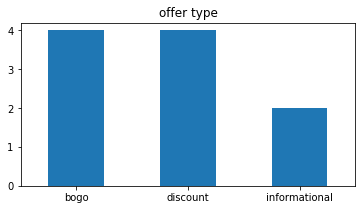

In [1772]:
pri_missing_perc(portfolio, 'offer_type')
category_plot(portfolio, 'offer_type', 'offer type', (6,3))

 0 (0.0%) missing values in difficulty 


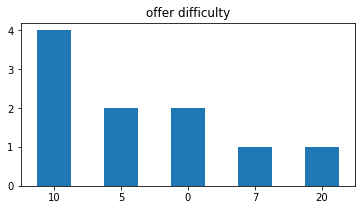

In [1773]:
# overall difficulties
pri_missing_perc(portfolio, 'difficulty')
category_plot(portfolio, 'difficulty', 'offer difficulty', (6,3))

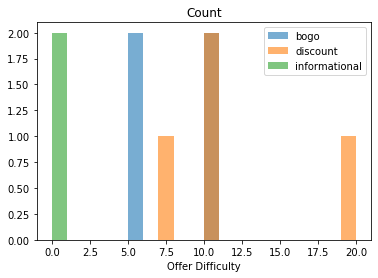

In [1774]:
# difficulties for each type of offer

# df['difficulty'].hist(by=df['offer_type'])

grouped = portfolio.groupby('offer_type')
plt.figure()
for group in grouped:
    plt.hist(group[1]['difficulty'],histtype='bar', bins=range(0,21,1), rwidth=1, label=group[0],  alpha=0.6, stacked=True)
plt.legend()
plt.title('Offer Difficulty for Different Offer Types')
plt.xlabel('Offer Difficulty')
plt.title('Count')
plt.show()


 0 (0.0%) missing values in duration 


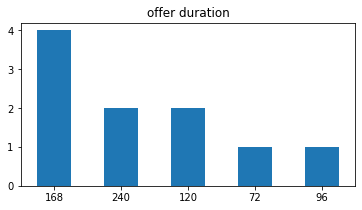

In [1775]:
pri_missing_perc(portfolio, 'duration')

# transfer duration of days into hours such that it can be compared to transaction time
portfolio['duration']=portfolio['duration']*24

category_plot(portfolio, 'duration', 'offer duration', (6,3))

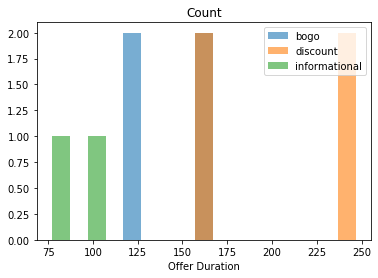

In [1776]:
grouped = portfolio.groupby('offer_type')

plt.figure()
for group in grouped:
    plt.hist(group[1]['duration'],histtype='bar', bins=range(portfolio['duration'].min(),portfolio['duration'].max()+20,20), rwidth=0.5, label=group[0],  alpha=0.6, stacked=True)
plt.legend()
plt.title('Offer Duration for Different Offer Types')
plt.xlabel('Offer Duration')
plt.title('Count')
plt.show()

In [1777]:
pri_missing_perc(portfolio, 'channels')
channel_types=set([x for i in list(portfolio['channels']) for x in i ])
print('types of offer channels:', channel_types)

 0 (0.0%) missing values in channels 
types of offer channels: {'mobile', 'web', 'email', 'social'}


In [1778]:
for x in channel_types:
    portfolio[x]=0
    portfolio.loc[pd.DataFrame(portfolio['channels'].tolist()).isin([x]).any(1),x]=1
portfolio.drop('channels', axis=1, inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,mobile,web,email,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,0,1,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [1779]:
portfolio.groupby('offer_type')[['email', 'social', 'web', 'mobile']].sum()

,email,social,web,mobile
offer_type,,,,
bogo,4,3,3,4
discount,4,2,4,3
informational,2,1,1,2


each offer type comes with four ways of promotion. Since we are not interested in finding out the most effective promting methods in this study, we will only count the total number of methods each offer was sent and they will be stored in "channels" in stead. 

In [1780]:
portfolio.loc[:,'channels']=portfolio['email']+portfolio['social']+portfolio['web']+portfolio['mobile']

to_be_dropped=['email','social','web']

from observation, it can be seen that for BOGO offer, reward==diffuculty. For informational offer, reward==difficulty==0. For discount offer, rewards is nearly proportional to difficulty. It makes sense to engineer a new feature based on them as the ratio between reward_diff_ratio. This new feature could be taken as the reward you get per difficulty level. 

In [1781]:
portfolio.loc[:,'reward_diff_ratio']=0
portfolio.loc[portfolio['difficulty']!=0,'reward_diff_ratio']=portfolio[portfolio['difficulty']!=0]['reward']/portfolio[portfolio['difficulty']!=0]['difficulty']
portfolio

# with new feature added, "reward" and "difficulty" can be dropped
to_be_dropped=['reward','difficulty']


## profile

In [1782]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1783]:
# check duplicates
profile.duplicated().any()

False

 2175 (12.7941%) missing values in gender 


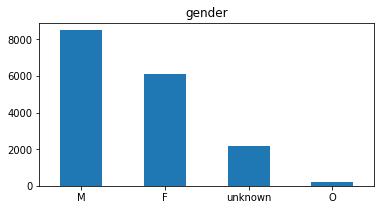

In [1784]:
pri_missing_perc(profile, 'gender')
profile['gender'].fillna('unknown', inplace =True) 

category_plot(profile, 'gender', 'gender', (6,3))

 2175 (12.7941%) missing values in income 


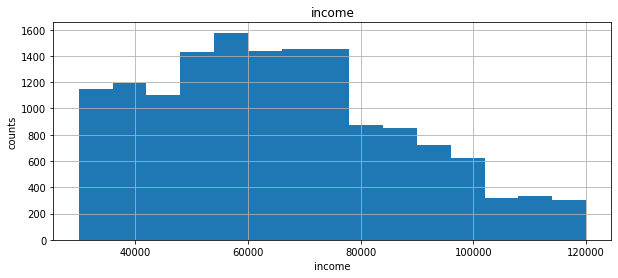

In [1785]:
pri_missing_perc(profile, 'income')
hist_plot(profile, 'income', 'income', figs=(10,4), nbin=15)

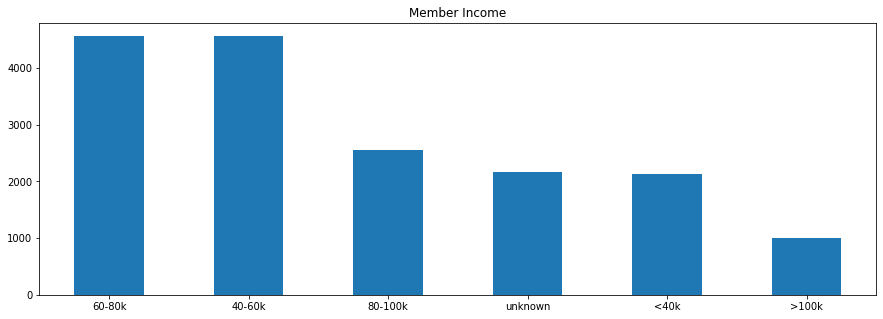

In [1786]:
# fill NULL

# # get median and mean
# print("Mean days as host:", round(profile['income'].mean(),2))
# print("Median days as host:", round(profile['income'].median(),2))

# profile['income'].fillna(profile['income'].median(), inplace=True)
# hist_plot(profile, 'income', 'income', figs=(10,4), nbin=10)

into_bins(profile,'income',bins=[0, 40000, 60000, 80000, 100000, 150000],
          labels=['<40k', '40-60k' ,'60-80k', '80-100k','>100k'])
category_plot(profile,'income', 'Member Income')

 0 (0.0%) missing values in age 


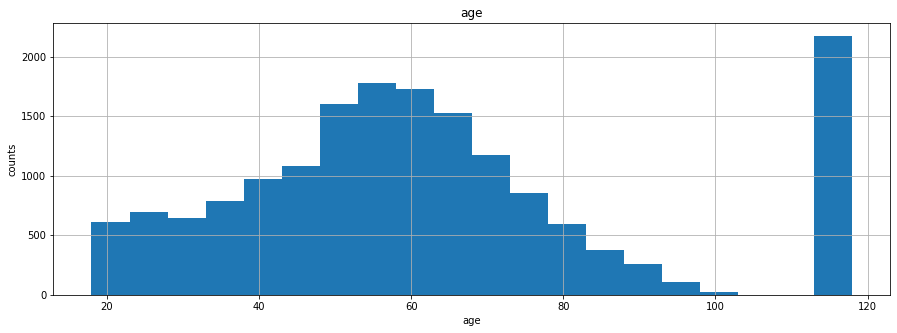

Max age: 118
Percentage of Age 118: 12.7941%


In [1787]:
pri_missing_perc(profile, 'age')
hist_plot(profile, 'age', 'age', figs=(15,5), nbin=20)

# get the value of outier
print("Max age:", profile['age'].max())
print('Percentage of Age 118: {}%'.format(round(profile[profile['age']==profile['age'].max()].shape[0]/profile.shape[0]*100, 4)))

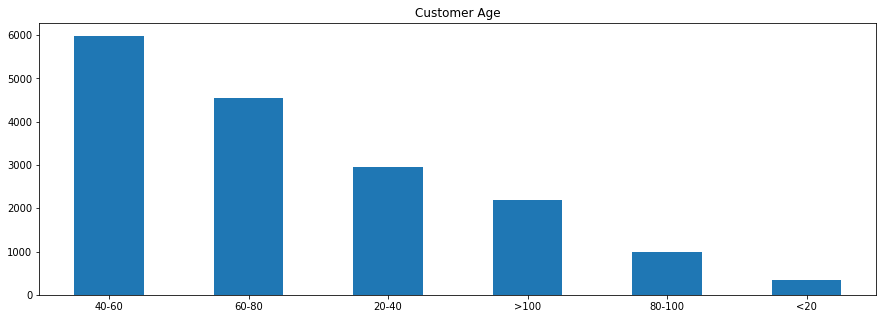

In [1788]:
into_bins(profile,'age',bins=[0, 20, 40, 60, 80, 100, 120],
          labels=['<20', '20-40', '40-60' ,'60-80', '80-100','>100'])
category_plot(profile,'age', 'Customer Age')

 0 (0.0%) missing values in became_member_on 


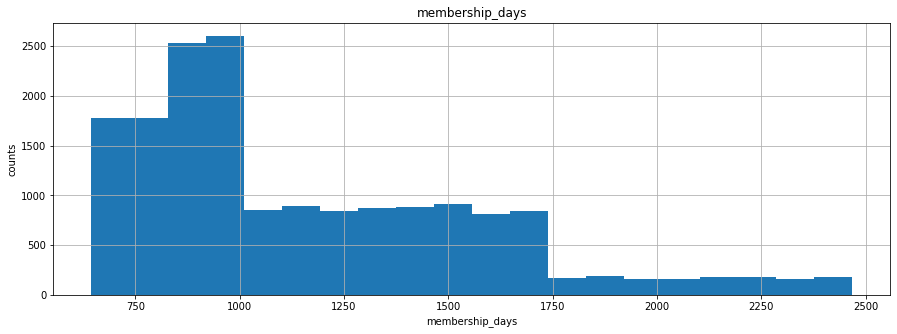

In [1789]:
pri_missing_perc(profile, 'became_member_on')

profile['became_member_on']=pd.to_datetime(profile['became_member_on'].astype('str'))
profile['membership_days']=(pd.to_datetime('20200501')-profile['became_member_on']).astype('timedelta64[D]')
profile.drop('became_member_on', axis=1, inplace=True)

hist_plot(profile, 'membership_days', 'membership_days', figs=(15,5), nbin=20)

In [1790]:
profile.duplicated().any()

False

In [1791]:
# after preprocessing
profile.head(10)

,gender,age,id,income,membership_days
0,unknown,>100,68be06ca386d4c31939f3a4f0e3dd783,unknown,1174.0
1,F,40-60,0610b486422d4921ae7d2bf64640c50b,>100k,1021.0
2,unknown,>100,38fe809add3b4fcf9315a9694bb96ff5,unknown,659.0
3,F,60-80,78afa995795e4d85b5d9ceeca43f5fef,80-100k,1088.0
4,unknown,>100,a03223e636434f42ac4c3df47e8bac43,unknown,1001.0
5,M,60-80,e2127556f4f64592b11af22de27a7932,60-80k,736.0
6,unknown,>100,8ec6ce2a7e7949b1bf142def7d0e0586,unknown,949.0
7,unknown,>100,68617ca6246f4fbc85e91a2a49552598,unknown,942.0
8,M,60-80,389bc3fa690240e798340f5a15918d5c,40-60k,812.0
9,unknown,>100,8974fc5686fe429db53ddde067b88302,unknown,1256.0


## transcript

In [1792]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


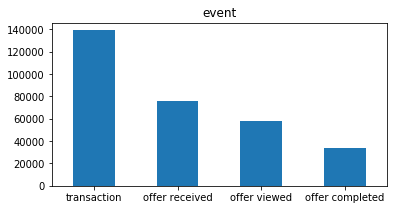

In [1793]:
category_plot(transcript, 'event', 'event', (6,3))

In [1794]:
key=set([i for item in list(transcript['value']) for i in item.keys()])
key

{'amount', 'offer id', 'offer_id', 'reward'}

In [1795]:
# split the value column into three columns: amount, offer id and 'reward'

transcript=pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)
transcript.loc[transcript['offer_id'].isna()==False, 'offer id']=transcript[transcript['offer_id'].isna()==False]['offer_id']
transcript.drop(['offer_id'], axis=1, inplace=True)


In [1796]:
# reward will not be considered as transaction amount, it will be deleted later
to_be_dropped.append('reward')

transcript[['offer id']]=transcript[['offer id']].fillna('unknown')
transcript[['amount']]=transcript[['amount']].fillna(0)


In [1797]:
print('Number of records', transcript.shape[0])
transcript.duplicated().any()

Number of records 306534


True

In [1798]:
transcript.drop_duplicates(inplace=True)
print('Number of records after dropping duplicates', transcript.shape[0])

Number of records after dropping duplicates 306137


### check total transaction amount

In [1799]:
transcript.groupby(['offer id'])['amount'].sum()

offer id
0b1e1539f2cc45b7b9fa7c272da2e1d7          0.00
2298d6c36e964ae4a3e7e9706d1fb8c2          0.00
2906b810c7d4411798c6938adc9daaa5          0.00
3f207df678b143eea3cee63160fa8bed          0.00
4d5c57ea9a6940dd891ad53e9dbe8da0          0.00
5a8bc65990b245e5a138643cd4eb9837          0.00
9b98b8c7a33c4b65b9aebfe6a799e6d9          0.00
ae264e3637204a6fb9bb56bc8210ddfd          0.00
f19421c1d4aa40978ebb69ca19b0e20d          0.00
fafdcd668e3743c1bb461111dcafc2a4          0.00
unknown                             1775451.97
Name: amount, dtype: float64

# Dataset Preparation and Analysis

<img src="flowchart.png" alt="Drawing" style="width: 450px;"/>

In [1800]:
# check
transcript.groupby(['offer id', 'event'])[['event']].count()

event
offer id                         event                  
0b1e1539f2cc45b7b9fa7c272da2e1d7 offer completed    3340
                                 offer received     7668
                                 offer viewed       2663
2298d6c36e964ae4a3e7e9706d1fb8c2 offer completed    5112
                                 offer received     7646
                                 offer viewed       7337
2906b810c7d4411798c6938adc9daaa5 offer completed    3964
                                 offer received     7632
                                 offer viewed       4118
3f207df678b143eea3cee63160fa8bed offer received     7617
                                 offer viewed       4144
4d5c57ea9a6940dd891ad53e9dbe8da0 offer completed    3301
                                 offer received     7593
                                 offer viewed       7298
5a8bc65990b245e5a138643cd4eb9837 offer received     7618
                                 offer viewed       6687
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer completed    4303
                                 offer received     7677
                                 offer viewed       4171
ae264e3637204a6fb9bb56bc8210ddfd offer completed    3635
                                 offer received     7658
                                 offer viewed       6716
f19421c1d4aa40978ebb69ca19b0e20d offer completed    4262
                                 offer received     7571
                                 offer viewed       7264
fafdcd668e3743c1bb461111dcafc2a4 offer completed    5265
                                 offer received     7597
                                 offer viewed       7327
unknown                          transaction      138953

## Find Effective Offers --> Offer-Driven Purchases

**Category**
* BOGO/Discount offer: "offer completed" event
* informational: "transaction"before offer expires

#### 1. For those whose "offer viewed" happen before "transaction", fill the transaction with "offer id" from "offer viewed" as they may be influenced by offer. Will determine if they are actually influenced by the offer later. 

Steps:
* sorting the transcript dataset by time and then event and group them by person. This will ensure that each event for each person occurs in the right sequence. 
* Then we can check if a "transaction" follows a "offer viewed" event. If so, then we assume that the transaction was potentially influenced by this offer, so we assign the "offer id" from "offer view" event to "transaction" event.  

In [1801]:
transcript['event'] = pd.Categorical(transcript['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])

transcript['pre_event']=transcript.sort_values(['time','event']).groupby(['person'])['event'].shift(1)
transcript['pre_offer']=transcript.sort_values(['time','event']).groupby(['person'])['offer id'].shift(1)
transcript.loc[((transcript['event']=='transaction') & (transcript['pre_event']=='offer viewed')), 'offer id']=transcript[((transcript['event']=='transaction') & (transcript['pre_event']=='offer viewed'))]['pre_offer']

transcript.head()


,person,event,time,offer id,amount,reward,pre_event,pre_offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,NaN,NaN,NaN


In [1802]:
# check
transcript.groupby(['offer id', 'event'])['event'].count()

offer id                          event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer received      7668
                                  offer viewed        2663
                                  transaction         1738
                                  offer completed     3340
2298d6c36e964ae4a3e7e9706d1fb8c2  offer received      7646
                                  offer viewed        7337
                                  transaction         5612
                                  offer completed     5112
2906b810c7d4411798c6938adc9daaa5  offer received      7632
                                  offer viewed        4118
                                  transaction         2831
                                  offer completed     3964
3f207df678b143eea3cee63160fa8bed  offer received      7617
                                  offer viewed        4144
                                  transaction         2677
                                  offer completed        0
4d5c57

In [1803]:
# check
transcript[transcript['event']=='transaction'].groupby(['offer id', 'event'])[['event']].count().sum()

event    138953.0
dtype: float64

#### 2.  Combining all three datasets
steps:
1. merge "profile" with "transcript" based on customer id
2. left merge the combined dataset with "portfolio" based on "offer id".

In [1862]:
# merge profile and transcripts based on customer id
df=profile.merge(transcript, left_on='id', right_on='person').drop('id', axis=1)
df.head()

,gender,age,income,membership_days,person,event,time,offer id,amount,reward,pre_event,pre_offer
0,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,168,2906b810c7d4411798c6938adc9daaa5,0.00,NaN,NaN,NaN
1,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,0.00,NaN,offer received,2906b810c7d4411798c6938adc9daaa5
2,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,NaN,offer viewed,2906b810c7d4411798c6938adc9daaa5
3,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,NaN,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,transaction,360,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.35,NaN,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [1863]:
# merge with offer portfolio based on offer id
df=df.merge(portfolio, left_on='offer id', right_on='id', how='left').drop('id', axis=1)
df.head()

,gender,age,income,membership_days,person,event,time,offer id,amount,reward_x,...,reward_y,difficulty,duration,offer_type,mobile,web,email,social,channels,reward_diff_ratio
0,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,168,2906b810c7d4411798c6938adc9daaa5,0.00,NaN,...,2.0,10.0,168.0,discount,1.0,1.0,1.0,0.0,3.0,0.20
1,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,0.00,NaN,...,2.0,10.0,168.0,discount,1.0,1.0,1.0,0.0,3.0,0.20
2,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,NaN,...,5.0,20.0,240.0,discount,0.0,1.0,1.0,0.0,2.0,0.25
3,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,NaN,...,5.0,20.0,240.0,discount,0.0,1.0,1.0,0.0,2.0,0.25
4,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,transaction,360,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.35,NaN,...,5.0,20.0,240.0,discount,0.0,1.0,1.0,0.0,2.0,0.25


#### 3. Check if offer is still valid at transaction

* get the difference between "transaction" and "offer received" as a new column named "time_since_receive". 
* since all BOGO/discount offers are marked with "offer completed", so it's not necessary to check if transaction activity with this type of offers is within the valid period of the offer. Only informational type of offer is checked here.

In [1864]:
# get difference in time
df['time_since_receive']=df[((df['event']=='offer received') | (df['event']=='transaction'))].groupby(['person','offer id'])['time'].diff()



**CAUTION**: df[df['time_since_receive']<df['duration']] may false positives rows for the following cases: 
* offer received - offer received
* transaction - transaction
* offer received - transaction

so "time_since_receive" < "duration" need to used along with other conditions, i.e.:
1. "time_since_receive" < "duration"
2. event == 'transaction'
3. "transaction" has a valid "offer id" (since this indicates this transaction is followed by "offer view" )

#### 4. considred to be an effective offer if the following criterias are met:
1. BOGO/Discount offer --> event is "offer completed"
2. Informational Offer 
    1. "time_since_receive" < "duration"  (time_since_receive is nan for other types of offers)
    2. event is "transaction" 
    3. "transaction" event has an "offer id", indicating it follows an "offer viewed" event

In [1865]:
# consider offer to be effective if time_since_receive<duration

# initialize all to 0
df['offer_driven']=0


# BOGO/Discount offers with "offer completed" happening after "offer viewed" 
df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])
df['pre_event']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_offer']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[((df['event']=='offer completed') & (df['pre_event']=='offer viewed')), 'offer_driven']=1


# offer viewed" before "transaction" AND "time_since_receive"<"duration"
df.loc[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['time_since_receive']<=df['duration']),'offer_driven']=1


## Inactive Customers _ Customers Never Made Any Purchases

In [1866]:
# find all customers with purchase history
cust_with_purchase=set(df[df['event'].isin(['offer completed', 'transaction'])].groupby('person')['event'].count().index.to_list())
cust_no_purchase=set(df[~df['person'].isin(cust_with_purchase)]['person'].to_list())
print("There are {} customers that never made a purchase".format(len(cust_no_purchase)))


There are 422 customers that never made a purchase


In [1867]:
len(set(df['person'].to_list()))
df['person'].unique()

array(['68be06ca386d4c31939f3a4f0e3dd783',
       '0610b486422d4921ae7d2bf64640c50b',
       '38fe809add3b4fcf9315a9694bb96ff5', ...,
       '01d26f638c274aa0b965d24cefe3183f',
       '9dc1421481194dcd9400aec7c9ae6366',
       'e4052622e5ba45a8b96b59aba68cf068'], dtype=object)

In [1868]:
# a new column "active_customer": 0: inactive; 1: active
df['active_customer']=1
df.loc[df['person'].isin(cust_no_purchase), 'active_customer']=0

## Offer-Irrelevant Purchases
1. standalone "transaction", those not following "offer viewed"
    * "offer id" is unknown
2. "transaction" followed "offer viewed", but
    1. BOGO/Discount offers with "transaction" only, not followed by "offer completed".
    2. Informational offers but transaction happens when offer expired.
   

In [1869]:
# initialize all to 0
df['offer_irrelevant']=0

# transaction not following "offer viewed" -- standalone transactions
df.loc[((df['event']=='transaction') & (df['offer id']=='unknown')), 'offer_irrelevant']=1

# transaction follows 'offer viewed', but time_since_receive>duration (informational offer)
df.loc[(df['offer id']!='unknown') & (df['event']=='transaction') & ((df['time_since_receive']>df['duration'])),'offer_irrelevant']=1



In [1870]:
# transaction follows 'offer viewed', but not followed by "offer completed" (BOGO/Discount offers)

df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])

df['post_event']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(-1)
df['post_offer']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(-1)


df.loc[((df['event']=='transaction') & (df['offer id']!='unknown') & (df['time_since_receive'].isnull()) & ((df['post_event']!='offer completed') | (df['post_offer']!=df['offer id']))), 'offer_irrelevant']=1


In [1871]:
# offer completed not following offer viewed

# BOGO/Discount offers with "offer completed" happening after "offer viewed" 
df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])
df['pre_event']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_offer']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[((df['event']=='offer completed') & ((df['pre_event']!='offer viewed') | (df['pre_event'].isnull()))), 'offer_irrelevant']=1


In [1872]:

df.groupby(['offer id', 'event'])['event'].count().head(50)


offer id                          event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer received      7668
                                  offer viewed        2663
                                  transaction         1738
                                  offer completed     3340
2298d6c36e964ae4a3e7e9706d1fb8c2  offer received      7646
                                  offer viewed        7337
                                  transaction         5612
                                  offer completed     5112
2906b810c7d4411798c6938adc9daaa5  offer received      7632
                                  offer viewed        4118
                                  transaction         2831
                                  offer completed     3964
3f207df678b143eea3cee63160fa8bed  offer received      7617
                                  offer viewed        4144
                                  transaction         2677
                                  offer completed        0
4d5c57

In [1873]:
# total purchase amount
print("total purchase amount with offers", round(df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount without offers", round(df[df['offer id']=='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount", round(df.groupby('offer id')['amount'].sum().sum()))

print("--------------------------------------------")


total purchase amount with offers 584549.0
total purchase amount without offers 1190903.0
total purchase amount 1775452.0
--------------------------------------------


In [1874]:
A=df[(df['event']=='transaction') & (df['offer_driven']==0) & (df['offer_irrelevant']==0)]
A.groupby(['offer id', 'event'])['event'].count()

Series([], Name: event, dtype: int64)

In [1875]:
B=df[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['time_since_receive'].isnull()) & (df['post_event']=='offer completed') & (df['post_offer']==df['offer id'])]
B.groupby(['offer id', 'event'])['event'].count()

Series([], Name: event, dtype: int64)

test

In [1876]:
df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df['person']=='072731be403a472883bed6c38a8e7aa8')][['time','event', 'pre_event', 'offer id', 'post_offer',  'offer_driven', 'offer_irrelevant','amount']]


,time,event,pre_event,offer id,post_offer,offer_driven,offer_irrelevant,amount
137384,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137385,354,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137386,354,transaction,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,15.75
137387,408,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137389,492,offer completed,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0.00
137390,516,offer viewed,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137391,564,transaction,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,14.24
137392,564,offer completed,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0.00


#### delete transactions before "offer completed" and copy transaction amount to "offer complete" event

In [1877]:
# backup
# # copy transaction amount to "offer complete" event
# df['pre_amount']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['amount'].shift(1)
# df['pre_offer']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)
# df['pre_event']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)

# df.loc[(df['event']=='offer completed') & (df['pre_event']=='transaction') & (df['pre_offer']==df['offer id']), 'amount']=df[(df['event']=='offer completed') & (df['pre_event']=='transaction') & (df['pre_offer']==df['offer id'])]['pre_amount'] 


# # delete transactions before "offer completed"

# df=df.drop(df[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['post_event']=='offer completed') & (df['post_offer']==df['offer id'])].index)


In [1878]:
# copy transaction amount to "offer complete" event
df['pre_amount']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['amount'].shift(1)
df['pre_offer']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)
df['pre_event']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)

df.loc[(df['event']=='offer completed') & (df['pre_event']=='transaction') & (df['pre_offer']==df['offer id']), 'amount']=df[(df['event']=='offer completed') & (df['pre_event']=='transaction') & (df['pre_offer']==df['offer id'])]['pre_amount'] 


# delete transactions before "offer completed"
df['post_event']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(-1)
df['post_offer']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(-1)

df=df.drop(df[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['post_event']=='offer completed') & (df['post_offer']==df['offer id'])].index)


In [1879]:
df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df['person']=='072731be403a472883bed6c38a8e7aa8')][['time','event', 'pre_event', 'offer id', 'post_event', 'post_offer',  'offer_driven', 'offer_irrelevant','amount']]


,time,event,pre_event,offer id,post_event,post_offer,offer_driven,offer_irrelevant,amount
137384,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,0,0.00
137385,354,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,0,0.00
137387,408,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,0,0.00
137389,492,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,15.75
137390,516,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,0,0.00
137392,564,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,1,0,14.24


In [1880]:
C=df[(df['event']=='transaction') & (df['offer_driven']==0) & (df['offer_irrelevant']==0)]
C.groupby(['offer id', 'event'])['event'].count()

Series([], Name: event, dtype: int64)

In [1881]:
D=df[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['time_since_receive'].isnull()) & (df['post_event']=='offer completed') & (df['post_offer']==df['offer id'])]
D.groupby(['offer id', 'event'])['event'].count()

Series([], Name: event, dtype: int64)

In [1882]:
df.groupby(['offer id', 'event'])[['event']].count().head(50)

event
offer id                         event                   
0b1e1539f2cc45b7b9fa7c272da2e1d7 offer received    7668.0
                                 offer viewed      2663.0
                                 transaction        615.0
                                 offer completed   3340.0
2298d6c36e964ae4a3e7e9706d1fb8c2 offer received    7646.0
                                 offer viewed      7337.0
                                 transaction       1544.0
                                 offer completed   5112.0
2906b810c7d4411798c6938adc9daaa5 offer received    7632.0
                                 offer viewed      4118.0
                                 transaction        892.0
                                 offer completed   3964.0
3f207df678b143eea3cee63160fa8bed offer received    7617.0
                                 offer viewed      4144.0
                                 transaction       2677.0
                                 offer completed      NaN
4d5c57ea9a6940dd891ad53e9dbe8da0 offer received    7593.0
                                 offer viewed      7298.0
                                 transaction       2820.0
                                 offer completed   3301.0
5a8bc65990b245e5a138643cd4eb9837 offer received    7618.0
                                 offer viewed      6687.0
                                 transaction       4522.0
                                 offer completed      NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received    7677.0
                                 offer viewed      4171.0
                                 transaction        959.0
                                 offer completed   4303.0
ae264e3637204a6fb9bb56bc8210ddfd offer received    7658.0
                                 offer viewed      6716.0
                                 transaction       2682.0
                                 offer completed   3635.0
f19421c1d4aa40978ebb69ca19b0e20d offer received    7571.0
                                 offer viewed      7264.0
                                 transaction       2056.0
                                 offer completed   4262.0
fafdcd668e3743c1bb461111dcafc2a4 offer received    7597.0
                                 offer viewed      7327.0
                                 transaction       1508.0
                                 offer completed   5265.0
unknown                          offer received       NaN
                                 offer viewed         NaN
                                 transaction      97039.0
                                 offer completed      NaN

In [1883]:
df.groupby(['offer id', 'event'])[['amount']].sum().head(50)

amount
offer id                         event                      
0b1e1539f2cc45b7b9fa7c272da2e1d7 offer received         0.00
                                 offer viewed           0.00
                                 transaction         5359.54
                                 offer completed    23391.71
2298d6c36e964ae4a3e7e9706d1fb8c2 offer received         0.00
                                 offer viewed           0.00
                                 transaction         9848.95
                                 offer completed    63587.95
2906b810c7d4411798c6938adc9daaa5 offer received         0.00
                                 offer viewed           0.00
                                 transaction         8008.39
                                 offer completed    36480.98
3f207df678b143eea3cee63160fa8bed offer received         0.00
                                 offer viewed           0.00
                                 transaction        41570.44
                                 offer completed         NaN
4d5c57ea9a6940dd891ad53e9dbe8da0 offer received         0.00
                                 offer viewed           0.00
                                 transaction        16967.47
                                 offer completed    57119.28
5a8bc65990b245e5a138643cd4eb9837 offer received         0.00
                                 offer viewed           0.00
                                 transaction        56366.03
                                 offer completed         NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received         0.00
                                 offer viewed           0.00
                                 transaction         8030.28
                                 offer completed    32478.11
ae264e3637204a6fb9bb56bc8210ddfd offer received         0.00
                                 offer viewed           0.00
                                 transaction        16707.88
                                 offer completed    51138.91
f19421c1d4aa40978ebb69ca19b0e20d offer received         0.00
                                 offer viewed           0.00
                                 transaction        13530.60
                                 offer completed    63149.45
fafdcd668e3743c1bb461111dcafc2a4 offer received         0.00
                                 offer viewed           0.00
                                 transaction        12921.57
                                 offer completed    67891.69
unknown                          offer received          NaN
                                 offer viewed            NaN
                                 transaction      1190902.74
                                 offer completed         NaN

In [1884]:
df.groupby(['offer id', 'event'])[['amount']].sum().sum()

amount    1775451.97
dtype: float64

In [1885]:
df.groupby(['offer id'])[['amount']].sum().head(50)

,amount
offer id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,28751.25
2298d6c36e964ae4a3e7e9706d1fb8c2,73436.90
2906b810c7d4411798c6938adc9daaa5,44489.37
3f207df678b143eea3cee63160fa8bed,41570.44
4d5c57ea9a6940dd891ad53e9dbe8da0,74086.75
5a8bc65990b245e5a138643cd4eb9837,56366.03
9b98b8c7a33c4b65b9aebfe6a799e6d9,40508.39
ae264e3637204a6fb9bb56bc8210ddfd,67846.79
f19421c1d4aa40978ebb69ca19b0e20d,76680.05


#### sanity check

all "transaction" event remaining shall be labeled either as "offer_irrelevant" or "offer_driven"

In [1886]:
df[(df['event']=='transaction') & (df['offer_irrelevant']==0) & (df['offer_driven']==0)].shape[0]

0

all "offer completed" event shall be labeled "offer_irrelevant"==0 and "offer_driven"==1

In [1887]:
df[(df['event']=='offer completed')]['offer_driven'].unique()

array([1, 0])

In [1888]:
df[(df['event']=='offer completed')]['offer_irrelevant'].unique()

array([0, 1])

all other events should be 0 for both offer_irrelevant and 'offer_driven'

In [1889]:
df[(df['event']!='offer completed')& (df['event']!='transaction')]['offer_irrelevant'].unique()

array([0])

In [1890]:
df[(df['event']!='offer completed')& (df['event']!='transaction')]['offer_driven'].unique()

array([0])

In [1891]:
# total purchase amount
print("total purchase amount with offers", round(df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount without offers", round(df[df['offer id']=='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount", round(df.groupby('offer id')['amount'].sum().sum()))

print("--------------------------------------------")

# number of purchases with offer 
print("number of purchases with offer", df[((df['event']=='transaction') & (df['offer id']!='unknown')) | (df['event']=='offer completed') ].shape[0] )
print("number of purchases without offer", df[(df['event']=='transaction') & (df['offer id']=='unknown')].shape[0])
print("total number of purchases", df[(df['event']=='transaction') | (df['event']=='offer completed')].shape[0])


total purchase amount with offers 584549.0
total purchase amount without offers 1190903.0
total purchase amount 1775452.0
--------------------------------------------
number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 150496


In [1892]:
# all purchases should be marked as either offer_driven or offer_irrelevant.
print("total number of purchases", df[(df['offer_driven']==1) | (df['offer_irrelevant']==1)].shape[0])

total number of purchases 150496


In [1893]:
df.groupby(['offer id', 'event'])[['amount']].sum()

amount
offer id                         event                      
0b1e1539f2cc45b7b9fa7c272da2e1d7 offer received         0.00
                                 offer viewed           0.00
                                 transaction         5359.54
                                 offer completed    23391.71
2298d6c36e964ae4a3e7e9706d1fb8c2 offer received         0.00
                                 offer viewed           0.00
                                 transaction         9848.95
                                 offer completed    63587.95
2906b810c7d4411798c6938adc9daaa5 offer received         0.00
                                 offer viewed           0.00
                                 transaction         8008.39
                                 offer completed    36480.98
3f207df678b143eea3cee63160fa8bed offer received         0.00
                                 offer viewed           0.00
                                 transaction        41570.44
                                 offer completed         NaN
4d5c57ea9a6940dd891ad53e9dbe8da0 offer received         0.00
                                 offer viewed           0.00
                                 transaction        16967.47
                                 offer completed    57119.28
5a8bc65990b245e5a138643cd4eb9837 offer received         0.00
                                 offer viewed           0.00
                                 transaction        56366.03
                                 offer completed         NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received         0.00
                                 offer viewed           0.00
                                 transaction         8030.28
                                 offer completed    32478.11
ae264e3637204a6fb9bb56bc8210ddfd offer received         0.00
                                 offer viewed           0.00
                                 transaction        16707.88
                                 offer completed    51138.91
f19421c1d4aa40978ebb69ca19b0e20d offer received         0.00
                                 offer viewed           0.00
                                 transaction        13530.60
                                 offer completed    63149.45
fafdcd668e3743c1bb461111dcafc2a4 offer received         0.00
                                 offer viewed           0.00
                                 transaction        12921.57
                                 offer completed    67891.69
unknown                          offer received          NaN
                                 offer viewed            NaN
                                 transaction      1190902.74
                                 offer completed         NaN

In [1894]:
df.groupby(['offer id'])[['amount']].sum()

,amount
offer id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,28751.25
2298d6c36e964ae4a3e7e9706d1fb8c2,73436.90
2906b810c7d4411798c6938adc9daaa5,44489.37
3f207df678b143eea3cee63160fa8bed,41570.44
4d5c57ea9a6940dd891ad53e9dbe8da0,74086.75
5a8bc65990b245e5a138643cd4eb9837,56366.03
9b98b8c7a33c4b65b9aebfe6a799e6d9,40508.39
ae264e3637204a6fb9bb56bc8210ddfd,67846.79
f19421c1d4aa40978ebb69ca19b0e20d,76680.05


In [1895]:
df.groupby(['offer id', 'event'])['event'].count()

offer id                          event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer received      7668
                                  offer viewed        2663
                                  transaction          615
                                  offer completed     3340
2298d6c36e964ae4a3e7e9706d1fb8c2  offer received      7646
                                  offer viewed        7337
                                  transaction         1544
                                  offer completed     5112
2906b810c7d4411798c6938adc9daaa5  offer received      7632
                                  offer viewed        4118
                                  transaction          892
                                  offer completed     3964
3f207df678b143eea3cee63160fa8bed  offer received      7617
                                  offer viewed        4144
                                  transaction         2677
                                  offer completed        0
4d5c57

In [1896]:
df_backup=df.copy()

df0=df.copy()

# df=df_backup.copy()

## More Dataset Exploration and Cleaning

### offer received each customer

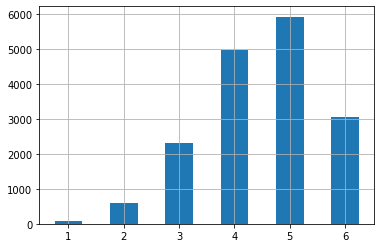

In [1897]:
df[df['event']=='offer received'].groupby('person')['event'].count().hist(bins=range(1,8), rwidth=0.5, align='left')


In [1898]:
offer_count=df[df['event']=='offer received'].groupby('person')[['event']].count().reset_index()

# check the customers that never received any offers
a=df['person'].unique()
b=offer_count['person'].unique()
print(np.setdiff1d(a,b))

# add the number of offer received to the dataset as a new feature
offer_count.rename(columns={"event": "offer_cnt"}, inplace=True)
df=df.merge(offer_count, right_on='person', left_on='person', how='left')
df['offer_cnt'].fillna(0, inplace=True)

['12ede229379747bd8d74ccdc20097ca3' '3a4874d8f0ef42b9a1b72294902afea9'
 'ae8111e7e8cd4b60a8d35c42c1110555' 'c6e579c6821c41d1a7a6a9cf936e91bb'
 'da7a7c0dcfcb41a8acc7864a53cf60fb' 'eb540099db834cf59001f83a4561aef3']


### Transaction Cleaning

**Goal**： keep 1 transaction history for each offer/order. 

**Summary** of the three features added before:
* offer_driven: all "offer_complete" event and qualified "transaction" event == 1
* active_customer: 
    * active customer == 1
    * inactive customer == 0 -- without any transaction/complete
* offer_irrelevant: all other "transaction" event not qualified as "offer_driven" == 1 


**Two ways to clean the data, can use a second method for sanity check purpose

**_method 1_:**
**Steps**:

* Event Type 1: start with "offer received"
    1. for inactive customers, keep "offer received" will result no info loss (**A**)
    2. for active customers, there are two scenerios:
        1. offer does not lead to purchases (**B**)
        2. offer leads to purchases  ---> labeled as "offer_drive"==1 (**C**)
            
* Event Type 2: standalone purchases (**D**)
    * labeled as "offer_irrelevant"==1


This way, we transferred all feature labels to "offer received" event. We can delete all other events with no info loss. 

a active customer may received multiple offers, but only 1 trasactions maybe, so need to keep "offer_received" event for all, but mark it as 1. at the end, keep all offer received event.


**_method 2_:**
**Steps**:
* **A** Each customer may received multiple offers. No matter they used it or not, it is a history of offer sent. So all "offer received" event should be kept. We add a new feature **keep** to flag all rows to be kept.
* **B** There may be standalone transactions without any offers. All of them don't have an "offer id". They will need to be kept.
* **C** For "transaction" (Informational offers), we would like to copy those labels from "transaction"events to their corresponding "offer received" events. 
* **D** For "offer completed" (BOGO/Discount offers), we would like to copy those labels from "offer completed"events to their corresponding "offer received" events. 


In [1899]:
df['keep']=0

**A**: "offer received" event for inactive customers

In [1900]:
# df.loc[(df['event']=='offer received') & (df['active_customer']==0), 'keep']=1
df.loc[(df['event']=='offer received') , 'keep']=1

In [1901]:
df.groupby(['offer id'])[['amount']].sum()

,amount
offer id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,28751.25
2298d6c36e964ae4a3e7e9706d1fb8c2,73436.90
2906b810c7d4411798c6938adc9daaa5,44489.37
3f207df678b143eea3cee63160fa8bed,41570.44
4d5c57ea9a6940dd891ad53e9dbe8da0,74086.75
5a8bc65990b245e5a138643cd4eb9837,56366.03
9b98b8c7a33c4b65b9aebfe6a799e6d9,40508.39
ae264e3637204a6fb9bb56bc8210ddfd,67846.79
f19421c1d4aa40978ebb69ca19b0e20d,76680.05


**B**: standalone purchases

In [1902]:
# standalone transactions
df.loc[((df['event'] == 'transaction') & (df['offer id'] == 'unknown')), 'keep']=1

In [1903]:
df.groupby(['offer id'])[['amount']].sum()

,amount
offer id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,28751.25
2298d6c36e964ae4a3e7e9706d1fb8c2,73436.90
2906b810c7d4411798c6938adc9daaa5,44489.37
3f207df678b143eea3cee63160fa8bed,41570.44
4d5c57ea9a6940dd891ad53e9dbe8da0,74086.75
5a8bc65990b245e5a138643cd4eb9837,56366.03
9b98b8c7a33c4b65b9aebfe6a799e6d9,40508.39
ae264e3637204a6fb9bb56bc8210ddfd,67846.79
f19421c1d4aa40978ebb69ca19b0e20d,76680.05


**C** & **D**
* shift(-1) to check if there is a "transaction" or "order completed" event follows an "offer received". 

In [1904]:
df['post_event']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(-1)
df['post_id']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(-1)

df['post_driven']=df[((df['event']=='offer received') | (df['event']=='transaction')  |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer_driven'].shift(-1)
df['post_irrelevant']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer_irrelevant'].shift(-1)

df['post_amount']=df[((df['event']=='offer received') | (df['event']=='transaction')  |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['amount'].shift(-1)


In [1905]:
df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df['person']=='072731be403a472883bed6c38a8e7aa8')][['keep','time','event', 'pre_event', 'offer id', 'post_id',  'offer_driven', 'offer_irrelevant','amount', 'post_driven', 'post_irrelevant','post_amount']]



,keep,time,event,pre_event,offer id,post_id,offer_driven,offer_irrelevant,amount,post_driven,post_irrelevant,post_amount
127716,1,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00,0.0,0.0,0.00
127717,0,354,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,0.00,NaN,NaN,NaN
127718,1,408,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00,1.0,0.0,15.75
127720,0,492,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,15.75,1.0,0.0,14.24
127721,0,516,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,0.00,NaN,NaN,NaN
127722,0,564,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,14.24,NaN,NaN,NaN


In [1906]:
# # flag offer related purchases on "offer receive event"
# df.loc[(df['event']=='offer received') & ( (~((df['post_event']=='offer completed') | (df['post_event']=='transaction'))) | (df['offer id'] != df['post_id'])), 'keep']=1


**C**: active customer, "offer received", has transactions
* "offer received" is followed by a "transaction" or "order completed" event with the same "offer id"

In [1907]:

# flag offer related purchases on "offer receive event" and copy the transaction amount to 'offer received event'
# df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), ['offer_irrelevant','offer_driven', 'amount']]=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])][['post_irrelevant', 'post_driven', 'post_amount']]

# offer received --> offer completed (including offer received --> transaction --> offer completed)
# offer received --> transaction

# mark those records as records to "keep"
df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'keep']=1


df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'offer_irrelevant']=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])]['post_irrelevant']
df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'offer_driven']=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])]['post_driven']
df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'amount']=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])]['post_amount']



In [1910]:
# df.loc[(df['event']=='offer received') & (df['pre_event']=='offer completed') & (df['offer id'] == df['pre_id']), 'keep']=1

In [1911]:
df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df['person']=='072731be403a472883bed6c38a8e7aa8')][['keep','time','event', 'pre_event', 'offer id', 'post_id',  'offer_driven', 'offer_irrelevant','amount', 'post_driven', 'post_irrelevant','post_amount']]



,keep,time,event,pre_event,offer id,post_id,offer_driven,offer_irrelevant,amount,post_driven,post_irrelevant,post_amount
127716,1,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0.00,0.0,0.0,0.00
127717,0,354,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0,0.0,0.00,NaN,NaN,NaN
127718,1,408,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,15.75,1.0,0.0,15.75
127720,0,492,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,15.75,1.0,0.0,14.24
127721,0,516,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0,0.0,0.00,NaN,NaN,NaN
127722,0,564,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1.0,0.0,14.24,NaN,NaN,NaN


#### other type of transactions that not happening with right order, but already marked with "offer_driven" or "offer_irrelevant"

In [1912]:
# offer received --> offer completed  --> transaction
df['pre_event']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_id']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[(df['event']=="transaction") & (df['pre_event']=="offer completed") & (df['keep']==0) & ((df['offer_driven']==1)|(df['offer_irrelevant']==1)), 'keep']=1


offer completed happens between two offer received events: offer recieved --> offer received --> offer completed --> offer completed

In [1913]:
df['pre_event']=df[((df['event']=='offer received') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_id']=df[((df['event']=='offer received') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[(df['event']=="offer completed") & (df['pre_event']=="offer completed") & (df['offer id']==df['pre_id']), 'keep']=1


In [1914]:
df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df['person']=='072731be403a472883bed6c38a8e7aa8')][['keep','time','event', 'pre_event', 'offer id', 'post_event',  'offer_driven', 'offer_irrelevant','amount', 'post_driven', 'post_irrelevant','post_amount']]


,keep,time,event,pre_event,offer id,post_event,offer_driven,offer_irrelevant,amount,post_driven,post_irrelevant,post_amount
127716,1,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0.0,0.0,0.00,0.0,0.0,0.00
127717,0,354,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0,0.0,0.00,NaN,NaN,NaN
127718,1,408,offer received,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,1.0,0.0,15.75,1.0,0.0,15.75
127720,0,492,offer completed,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,1.0,0.0,15.75,1.0,0.0,14.24
127721,0,516,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0,0.0,0.00,NaN,NaN,NaN
127722,1,564,offer completed,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1.0,0.0,14.24,NaN,NaN,NaN


### Dataset Clean

In [1915]:
n_pre_record=df.shape[0]
df=df[(df['keep']==1)]
print("{} records before cleaning. {} records after cleaning".format(n_pre_record,df.shape[0]))

284498 records before cleaning. 176043 records after cleaning


## Comparison
df

df0

In [1916]:
df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum()

offer id
0b1e1539f2cc45b7b9fa7c272da2e1d7    28751.25
2298d6c36e964ae4a3e7e9706d1fb8c2    73436.90
2906b810c7d4411798c6938adc9daaa5    44489.37
3f207df678b143eea3cee63160fa8bed    41570.44
4d5c57ea9a6940dd891ad53e9dbe8da0    74086.75
5a8bc65990b245e5a138643cd4eb9837    56366.03
9b98b8c7a33c4b65b9aebfe6a799e6d9    40508.39
ae264e3637204a6fb9bb56bc8210ddfd    67846.79
f19421c1d4aa40978ebb69ca19b0e20d    76680.05
fafdcd668e3743c1bb461111dcafc2a4    80813.26
Name: amount, dtype: float64

In [1917]:
df0[df0['offer id']!='unknown'].groupby('offer id')['amount'].sum()

offer id
0b1e1539f2cc45b7b9fa7c272da2e1d7    28751.25
2298d6c36e964ae4a3e7e9706d1fb8c2    73436.90
2906b810c7d4411798c6938adc9daaa5    44489.37
3f207df678b143eea3cee63160fa8bed    41570.44
4d5c57ea9a6940dd891ad53e9dbe8da0    74086.75
5a8bc65990b245e5a138643cd4eb9837    56366.03
9b98b8c7a33c4b65b9aebfe6a799e6d9    40508.39
ae264e3637204a6fb9bb56bc8210ddfd    67846.79
f19421c1d4aa40978ebb69ca19b0e20d    76680.05
fafdcd668e3743c1bb461111dcafc2a4    80813.26
Name: amount, dtype: float64

In [1918]:
a=set(df.index.to_list())
b=set(df0.index.to_list())
b-a;

In [1919]:
A=df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7') & (df['amount']>0)].groupby('person')['amount'].sum()

In [1922]:
B=df0[(df0['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7') & (df0['amount']>0)].groupby('person')['amount'].sum()

In [1923]:
A[~A.isin(B.values)]

Series([], Name: amount, dtype: float64)

In [1924]:
df[(df['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df['person']=='072731be403a472883bed6c38a8e7aa8')][['keep','time','event', 'pre_event', 'offer id', 'post_id',  'offer_driven', 'offer_irrelevant','amount', 'post_driven', 'post_irrelevant','post_amount']]


,keep,time,event,pre_event,offer id,post_id,offer_driven,offer_irrelevant,amount,post_driven,post_irrelevant,post_amount
127716,1,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0.00,0.0,0.0,0.00
127718,1,408,offer received,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,15.75,1.0,0.0,15.75
127722,1,564,offer completed,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1.0,0.0,14.24,NaN,NaN,NaN


In [1925]:
df0[(df0['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df0['person']=='072731be403a472883bed6c38a8e7aa8')][['time','event', 'pre_event', 'offer id', 'post_offer',  'offer_driven', 'offer_irrelevant','amount']]


,time,event,pre_event,offer id,post_offer,offer_driven,offer_irrelevant,amount
137384,336,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,0.00
137385,354,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,0.00
137387,408,offer received,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,0.00
137389,492,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,15.75
137390,516,offer viewed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,0.00
137392,564,offer completed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,14.24


In [1926]:
df00[(df00['offer id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')& (df0['person']=='072731be403a472883bed6c38a8e7aa8')][['time','event', 'post_event', 'offer id', 'post_offer',  'offer_driven', 'offer_irrelevant','amount']]


,time,event,post_event,offer id,post_offer,offer_driven,offer_irrelevant,amount
137384,336,offer received,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137385,354,offer viewed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137387,408,offer received,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137389,492,offer completed,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0.00
137390,516,offer viewed,transaction,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0.00
137392,564,offer completed,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,14.24


In [ ]:
df0.groupby(['offer id', 'event'])[['amount']].sum().sum()

### Sanity Checks

use method 2 to check if everything was done correclty

In [ ]:
df1.loc[(df1['event']=='offer received'), 'keep']=1

df1['post_event']=df1[((df1['event']=='offer received') | ((df1['event']=='transaction') & ((df1['offer_irrelevant']==1) | (df1['offer_driven']==1))) |(df1['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(-1)
df1['post_id']=df1[((df1['event']=='offer received') | ((df1['event']=='transaction') & ((df1['offer_irrelevant']==1) | (df1['offer_driven']==1))) |(df1['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(-1)

df1['post_driven']=df1[((df1['event']=='offer received') | ((df1['event']=='transaction') & ((df1['offer_irrelevant']==1) | (df1['offer_driven']==1))) |(df1['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer_driven'].shift(-1)
df1['post_irrelevant']=df1[((df1['event']=='offer received') | ((df1['event']=='transaction') & ((df1['offer_irrelevant']==1) | (df1['offer_driven']==1))) |(df1['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer_irrelevant'].shift(-1)


# flag offer related purchases on "offer receive event"
df1.loc[(df1['event']=='offer received') & ((df1['post_event']=='offer completed') | (df1['post_event']=='transaction')) & (df1['offer id'] == df1['post_id']), 'offer_irrelevant']=df1[(df1['event']=='offer received') & ((df1['post_event']=='offer completed') | (df1['post_event']=='transaction')) & (df1['offer id'] == df1['post_id'])]['post_irrelevant']
df1.loc[(df1['event']=='offer received') & ((df1['post_event']=='offer completed') | (df1['post_event']=='transaction')) & (df1['offer id'] == df1['post_id']), 'offer_driven']=df1[(df1['event']=='offer received') & ((df1['post_event']=='offer completed') | (df1['post_event']=='transaction')) & (df1['offer id'] == df1['post_id'])]['post_driven']

# mark those records as records to "keep"
df1.loc[(df1['event']=='offer received') & ((df1['post_event']=='offer completed') | (df1['post_event']=='transaction')) & (df1['offer id'] == df1['post_id']), 'keep']=1


# standalone transactions
df1.loc[((df1['event'] == 'transaction') & (df1['offer id'] == 'unknown')), 'keep']=1


# check number of "offer received" event before and after cleaning
n_pre_record=df1.shape[0]
df1=df1[(df1['keep']==1)]
print("{} records before cleaning. {} records after cleaning".format(n_pre_record,df1.shape[0]))


check distribution of number of offers received each person

In [ ]:

df[df['event']=='offer received'].groupby('person')['event'].count().hist(bins=range(1,8), rwidth=0.5, align='left')


In [ ]:
df[(df['event']=='transaction') & ((df['offer_driven']==0) & (df['offer_irrelevant']==0))]

In [ ]:
# number of standalone transactions
# df[(df['event']=='transaction')].shape[0]

# equals
df[(df['offer id']=='unknown')].shape[0]

In [ ]:
df[((df['event']=='offer received') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1)))].shape[0]


In [ ]:
df[(df['offer id']!='unknown')]['offer_driven'].unique()

In [1935]:
# total purchase amount
print("total purchase amount with offers", round(df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount without offers", round(df[df['offer id']=='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount", round(df.groupby('offer id')['amount'].sum().sum()))

print("--------------------------------------------")

# number of purchases with offer 
print("number of purchases with offer", df[(df['offer id']!='unknown') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1))].shape[0] )
print("number of purchases without offer", df[(df['offer id']=='unknown')].shape[0])
print("total number of purchases", df[(df['event']=='transaction') | ((df['event']=='offer received') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1)))].shape[0])


total purchase amount with offers 584549.0
total purchase amount without offers 1190903.0
total purchase amount 1775452.0
--------------------------------------------
number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 150415


In [1942]:
# number of purchases with offer 
print("number of purchases with offer", df[ (df['offer id']!='unknown') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1))].shape[0] )
print("number of purchases without offer", df[(df['offer id']=='unknown')].shape[0])
print("total number of purchases", df[(df['event']=='transaction') | (df['event']=='offer completed')| ((df['event']=='offer received') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1)))].shape[0])


number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 150496


In [1939]:
# number of purchases with offer 
print("number of purchases with offer", df0[ (df0['offer id']!='unknown') & ((df0['offer_driven']==1) | (df0['offer_irrelevant']==1))].shape[0] )
print("number of purchases without offer", df[(df['offer id']=='unknown')].shape[0])
print("total number of purchases", df0[(df0['event']=='transaction') | ((df0['event']=='offer received') & ((df0['offer_driven']==1) | (df0['offer_irrelevant']==1)))].shape[0])


number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 117314


In [1941]:
# number of purchases with offer 
print("number of purchases with offer", df0[((df0['event']=='transaction') & (df0['offer id']!='unknown')) | (df0['event']=='offer completed') ].shape[0] )
print("number of purchases without offer", df[(df['event']=='transaction') & (df['offer id']=='unknown')].shape[0])
print("total number of purchases", df0[(df0['event']=='transaction') | (df0['event']=='offer completed')].shape[0])


number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 150496


In [ ]:
df.isnull().any()

In [ ]:
df.columns

In [ ]:
# Drop unnecessary columns
to_be_dropped.append[
    'pre_event', 'pre_offer', 'post_event', 'post_offer', 'post_driven','post_irrelevant', 'post_id',  
    'time_since_receive', 'time',
    'event']
to_be_dropped=[x for i in to_be_dropped]
df=df.drop(columns_to_drop, axis=1)

## More Analysis

In [ ]:
df[df['event']=='offer received'].groupby('person')['event'].count().hist(bins=range(1,8), rwidth=0.5, align='left')
# offer_count=df[df['event']=='offer received'].groupby('person')[['event']].count().reset_index()

# # check the customers that never received any offers
# a=df['person'].unique()
# b=offer_count['person'].unique()
# np.setdiff1d(a,b)

# # add the number of offer received to the dataset as a new feature
# offer_count.rename(columns={"event": "offer_cnt"}, inplace=True)
# df=df.merge(offer_count, right_on='person', left_on='person', how='left')
# df['offer_cnt'].fillna(0, inplace=True)

In [ ]:
df[df['offer id']!='unknown'].groupby('person')['offer id'].count().hist(bins=range(1,8), rwidth=0.5, align='left')

In [ ]:
df[df['offer id']!='unknown'].groupby('person')['offer id'].count().hist(bins=range(1,8), rwidth=0.5, align='left')
offer_count=df[df['event']=='offer received'].groupby('person')[['event']].count().reset_index()

# check the customers that never received any offers
a=df['person'].unique()
b=offer_count['person'].unique()
np.setdiff1d(a,b)

# add the number of offer received to the dataset as a new feature
offer_count.rename(columns={"event": "offer_cnt"}, inplace=True)
df=df.merge(offer_count, right_on='person', left_on='person', how='left')
df['offer_cnt'].fillna(0, inplace=True)

#### How each gender response to offers

In [ ]:
df.grouby('gender')[['offer_drive', 'offer_irrelevant', 'inactive_customer']].sum()

#### Sales Amount associated with each offer

In [ ]:
df.groupby("offer id")['amount'].sum()

## Analysis

In [ ]:
df2=df[df['person']=='bc3abab34eb24ac9a44a6af6256dde4c'].copy()



df2['diff_info']=df2[(df2['offer_type']=='informational') & ((df2['event']=='offer received') | (df2['event']=='transaction'))].groupby(['person','offer id'])[['time']].diff()

print(df2.shape[0])
df2[['person', 'offer id', 'time', 'event', 'offer_type', 'diff_info']]



In [ ]:
df['pre_event']=df.sort_values('time').groupby(['person','offer id'])['event'].shift(1)
df['pre_offer']=df.sort_values('time').groupby(['person','offer id'])['offer id'].shift(1)
df[(df['event']=='transaction') & (df['pre_event']=='offer viewed')]['offer id']=df[(df['event']=='transaction') & (df['pre_event']=='offer viewed')]['pre_offer']
df[(df['event']=='transaction')]['person'].unique()

# Modeling

In [ ]:
# # find offer driven purchases ( Offer viewed & Offer complete & Offer is not expired)
# df['offer_drive_purchase']=False
# df[df['time']<df['duration'] & df['person'].isin(offer_complete_ls)]['offer_drive_purchase']=True